# Building a RNN on SMILES data

In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

%run ../assets/accuracy_loss_plots.py # function to plot accuracy and loss
%run ../assets/confusion_matrix.py # function to plot confusion matrix
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

## Read in data

In [48]:
df = pd.read_csv("../data/CID_properties_nr.csv")

In [49]:
# lowercase column names
df.columns = df.columns.str.lower()

In [50]:
# remove extra classes
index_names = df[(df["drug_class"] == "antineoplastic") | (df["drug_class"] == "cns") | (df["drug_class"] == "cardio")].index

df = df.loc[index_names]

In [51]:
df["drug_class"].value_counts()

antineoplastic    1174
cns               1141
cardio             787
Name: drug_class, dtype: int64

## Set up X and y variables

In [52]:
# Make my drug class variable categorical

In [53]:
classes_dict = {
    "antineoplastic": 0,
    "cns": 1,
    "cardio": 2}

In [54]:
# map drug classes to numerical
df['drug_class'] = df['drug_class'].map(classes_dict)
df.head()

,cid,hbondacceptorcount,hbonddonorcount,isomericsmiles,molecularweight,xlogp,drug_class,desalted_smiles
1,134694070,9,6,C1CN=C(N1)NC2=C(C3=NC=CN=C3C=C2)Br.[C@@H](C(C(...,442.226,NaN,2,Brc1c(NC2=NCCN2)ccc2nccnc12
3,4660557,1,1,C1C2CC3CC1CC(C2)C3NC4=CC=C(C=C4)Br,306.247,5.0,1,Brc1ccc(NC2C3CC4CC(C3)CC2C4)cc1
4,122175,2,2,CC(CCC(C#C)N)N,126.203,-0.4,0,C#CC(N)CCC(C)N
5,5281077,1,1,CCC(/C=C/Cl)(C#C)O,144.598,1.5,1,C#CC(O)(/C=C/Cl)CC
12,92913,1,1,CC(CC1=CC=CC=C1)N(C)CC#C.Cl,223.744,NaN,1,C#CCN(C)C(C)Cc1ccccc1


In [55]:
# check that the values are still the same
df["drug_class"].value_counts()

0    1174
1    1141
2     787
Name: drug_class, dtype: int64

In [56]:
# set up my X and y variables
X = df["desalted_smiles"]
y = df["drug_class"]

In [57]:
# Split my train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, random_state = 42)

## Preprocess Text

In [58]:
# set up tokenizer
tokenizer = Tokenizer(char_level=True, lower = False )
tokenizer.fit_on_texts(df["desalted_smiles"])
sequence_of_int = tokenizer.texts_to_sequences(df["desalted_smiles"])

In [59]:
X_train_tk = tokenizer.texts_to_matrix(X_train, mode='count' )
X_test_tk = tokenizer.texts_to_matrix(X_test, mode='count' )

In [60]:
# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50 unique tokens.


In [61]:
# tokenizer keeps the special characters by default! 
# This is useful for me since the special characters have significance in SMILES
word_index

{'C': 1,
 'c': 2,
 '(': 3,
 ')': 4,
 'O': 5,
 '@': 6,
 '1': 7,
 '[': 8,
 ']': 9,
 '=': 10,
 'H': 11,
 'N': 12,
 '2': 13,
 '3': 14,
 'n': 15,
 '4': 16,
 '/': 17,
 '5': 18,
 '-': 19,
 'S': 20,
 'l': 21,
 'F': 22,
 '+': 23,
 '6': 24,
 '\\': 25,
 '.': 26,
 'P': 27,
 '#': 28,
 's': 29,
 'o': 30,
 '7': 31,
 'B': 32,
 'r': 33,
 '8': 34,
 't': 35,
 'I': 36,
 '9': 37,
 'e': 38,
 'A': 39,
 'G': 40,
 'm': 41,
 'M': 42,
 '%': 43,
 '0': 44,
 'i': 45,
 'T': 46,
 'u': 47,
 'a': 48,
 'b': 49,
 'X': 50}

# Build model

In [62]:
model = Sequential()
model.add(Embedding(500,32))
model.add(SimpleRNN(51))
model.add(Dense(3, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          16000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 51)                4284      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 156       
Total params: 20,440
Trainable params: 20,440
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer = "adam", loss =  "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [65]:
history = model.fit(X_train_tk, y_train,
                   epochs = 30,
                   batch_size = 128, 
                   validation_data = (X_test_tk, y_test))

Train on 2326 samples, validate on 776 samples
Epoch 1/30
2326/2326 [==============================] - 0s 166us/sample - loss: 0.5130 - accuracy: 0.7863 - val_loss: 0.8477 - val_accuracy: 0.6482
Epoch 2/30
2326/2326 [==============================] - 0s 157us/sample - loss: 0.5234 - accuracy: 0.7859 - val_loss: 0.8366 - val_accuracy: 0.6559
Epoch 3/30
2326/2326 [==============================] - 0s 144us/sample - loss: 0.5148 - accuracy: 0.7876 - val_loss: 0.8792 - val_accuracy: 0.6392
Epoch 4/30
2326/2326 [==============================] - 0s 153us/sample - loss: 0.4990 - accuracy: 0.7919 - val_loss: 0.8629 - val_accuracy: 0.6559
Epoch 5/30
2326/2326 [==============================] - 0s 143us/sample - loss: 0.4770 - accuracy: 0.8065 - val_loss: 0.8397 - val_accuracy: 0.6662
Epoch 6/30
2326/2326 [==============================] - 0s 148us/sample - loss: 0.4468 - accuracy: 0.8220 - val_loss: 0.8380 - val_accuracy: 0.6791
Epoch 7/30
2326/2326 [==============================] - 0s 157us/

### Evaluate Model

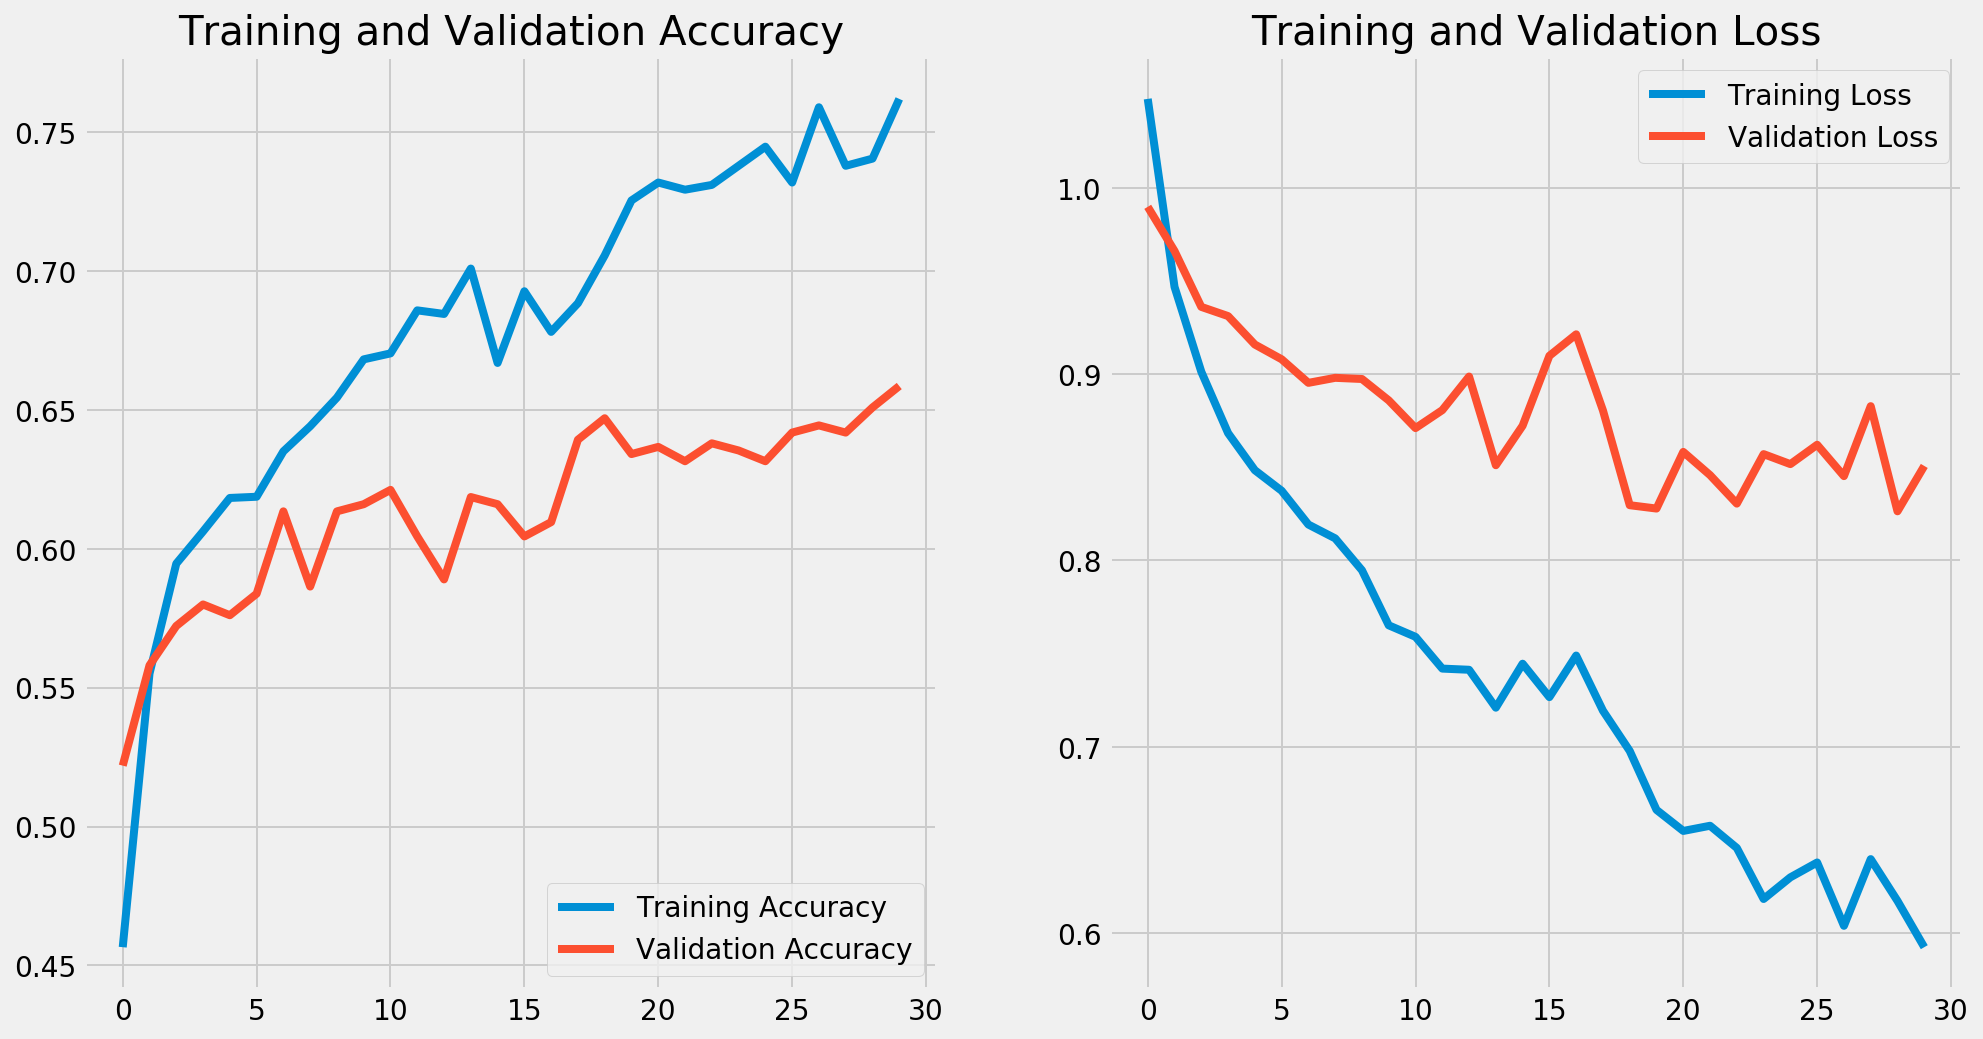

In [42]:
# plot accuracy and loss for model
plot_accuracy_loss(history, epochs = 30);
#plt.savefig("../plots/accuracy_loss_rnn.png")

## Generate predictions

In [66]:
# make predictions on test set
preds = model.predict_classes(X_test_tk)

In [67]:
val_acc = round(history.history['val_accuracy'][-1], 2)

Confusion matrix, without normalization
[[217  51  26]
 [ 53 172  60]
 [ 31  48 118]]


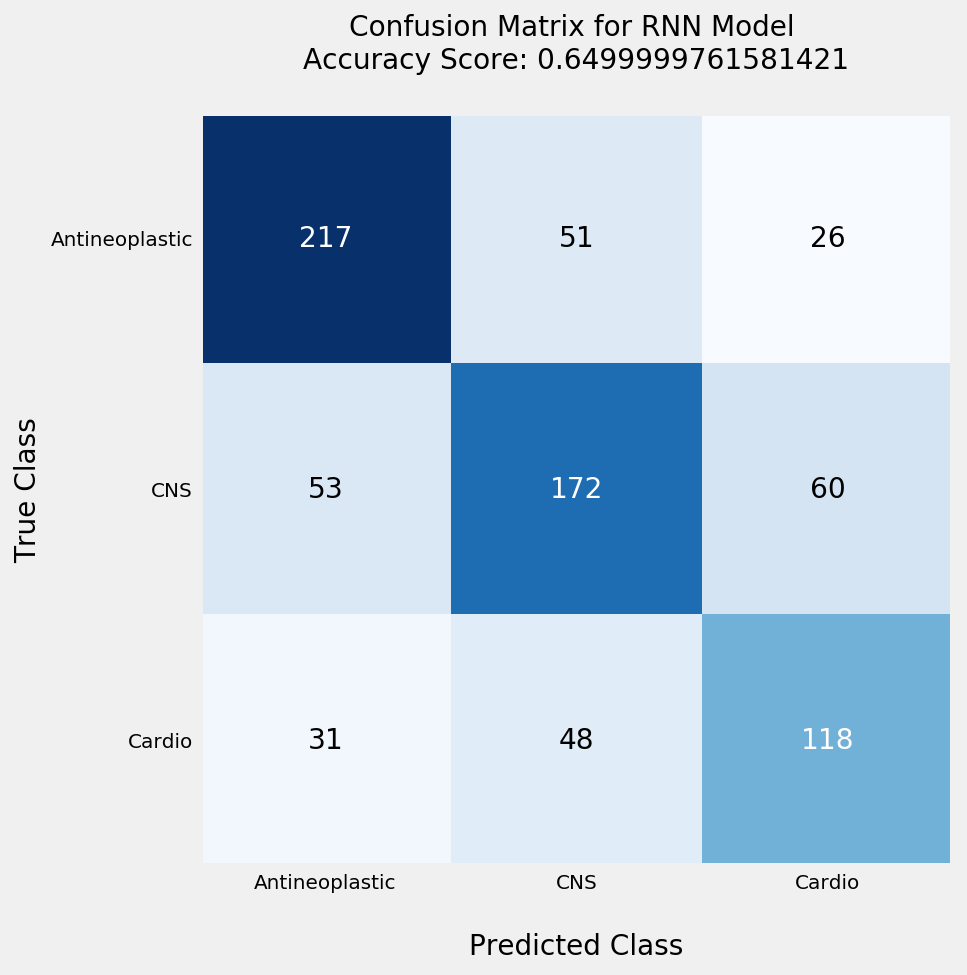

In [68]:
# Look at confusion matrix
cnf_matrix = confusion_matrix(y_test, preds,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix, classes=['Antineoplastic', 'CNS', 'Cardio'],
                      title=f'Confusion Matrix for RNN Model \nAccuracy Score: {val_acc}\n' )
plt.savefig("../plots/confusion_matrix_rnn.png", dpi = 150);

### Save Model

In [70]:
#save model
model.save("../assets/model_rnn.h5")